In [4]:
from datetime import datetime
from typing import Optional

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sqlalchemy import select, BinaryExpression, func

from src.const import BASE_DATA_PATH
from src.db.db_mgmt import DatabaseConfig, DatabaseManager
from src.db.db_models import DBPost, DBCollectionTask

conf = DatabaseConfig("sqlite", (BASE_DATA_PATH / "youtube.sqlite").as_posix())
db = DatabaseManager(conf)


# todo use misc.helper
def get_posts(platform: str,
              conditions: Optional[BinaryExpression | list[BinaryExpression]] = None
              ) -> list[DBPost]:
    with db.get_session() as session:
        # Start with a base query
        query = select(
            func.date(DBPost.date_created).label('day'),
            func.count().label('count')
        ).group_by(
            func.date(DBPost.date_created)
        )

        # Platform is required
        query = query.where(DBPost.platform == platform)

        if conditions is not None:
            if isinstance(conditions, list):
                for condition in conditions:
                    query = query.where(condition)
            else:
                query = query.where(conditions)

        # Execute the query and return the results
        result = session.execute(query)
        return result.all()


In [5]:
def get_year_counts(year: int) -> pd.Series:
    results = get_posts("youtube",
                        conditions=DBPost.date_created.between(
                            datetime(year, 1, 1),
                            datetime(year + 1, 1, 1)
                        ))

    # Convert to pandas Series with days as index
    counts = pd.Series({row[0]: row[1] for row in results})
    return counts

#get_year_counts(2022)

In [6]:
import matplotlib.dates as mdates


def plot_daily_items(daily_counts: pd.Series):
    plt.figure(figsize=(12, 6))

    # Convert index to datetime if not already
    if not isinstance(daily_counts.index, pd.DatetimeIndex):
        daily_counts.index = pd.to_datetime(daily_counts.index)

    sns.lineplot(data=daily_counts, color='blue', label='Posts')

    # Zero days highlight
    zero_days = daily_counts[daily_counts == 0]
    if not zero_days.empty:
        plt.scatter(zero_days.index, zero_days.values,
                    color='red', s=10, label='No Posts',
                    zorder=5)

    plt.title('Daily Post Count (Red Dots = No Posts)')
    plt.xlabel('Date')
    plt.ylabel('Number of Posts')

    # Improved x-axis labels
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)

    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    return plt


In [4]:
get_year_counts(2022)

2022-01-01    55
2022-01-02    75
2022-01-03    66
2022-01-04    53
2022-01-05    56
              ..
2022-12-27    24
2022-12-28    17
2022-12-29    23
2022-12-30    24
2022-12-31    20
Length: 365, dtype: int64

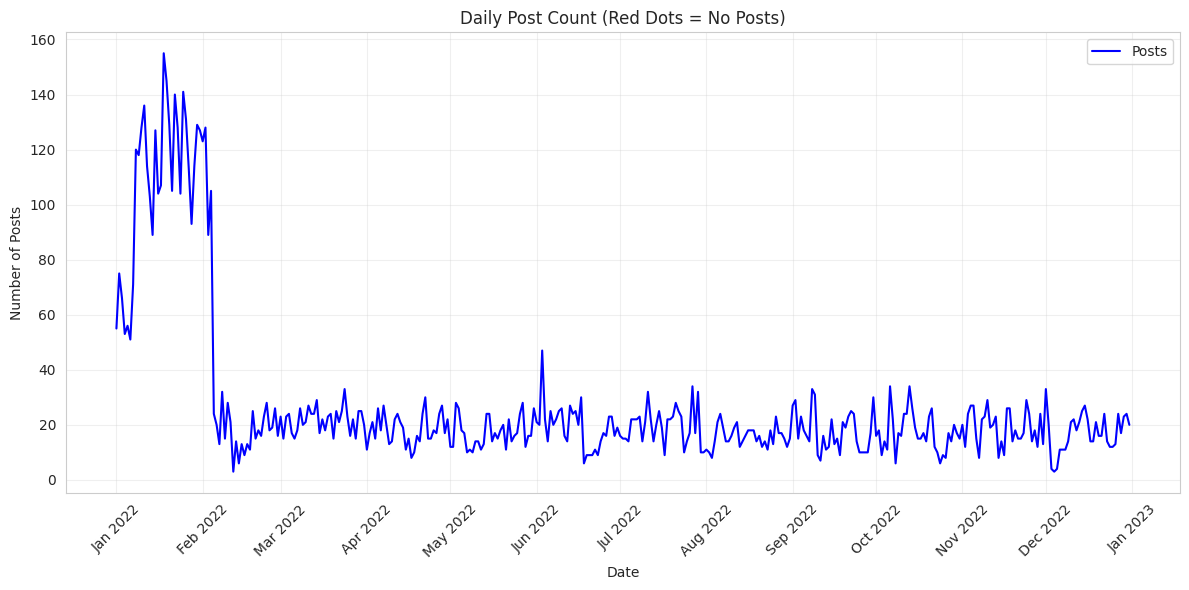

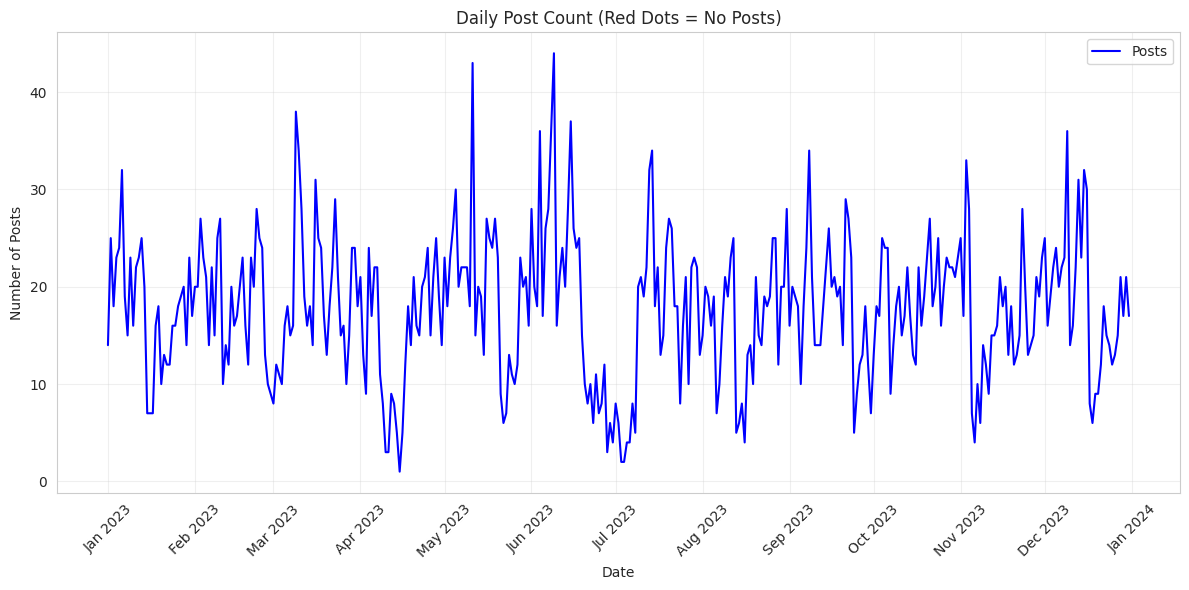

In [7]:

yc_2022 = get_year_counts(2022)
plot = plot_daily_items(yc_2022)
plot.show()
yc_2023 = get_year_counts(2023)
plot = plot_daily_items(yc_2023)
plot.show()

In [8]:
from sqlalchemy.orm import contains_eager


# todo use misc.helper
def get_posts_w_task(platform: str,
                     conditions: Optional[BinaryExpression | list[BinaryExpression]] = None
                     ) -> list[DBPost]:
    with db.get_session() as session:
        # Start with a base query
        query = select(DBPost, DBCollectionTask).join(
            DBCollectionTask,
            DBPost.collection_task_id == DBCollectionTask.id
        ).options(
            contains_eager(DBPost.collection_task)
        )

        # Platform is required
        query = query.where(DBPost.platform == platform)

        if conditions is not None:
            if isinstance(conditions, list):
                for condition in conditions:
                    query = query.where(condition)
            else:
                query = query.where(conditions)

        # Execute the query and return the results
        res = session.execute(query).all()
        return [(post.model(),post_col_task.model()) for post, post_col_task in res]

jan_2022 = get_posts_w_task("youtube", conditions=DBPost.date_created.between(
    datetime(2022, 1, 1),
    datetime(2022, 2, 1)
))

In [16]:
# for post, post_col in jan_2022:
#     print(post_col.collection_config)

len(jan_2022), len([_ for _, post_col in jan_2022 if post_col.collection_config.get("location")])

(3327, 2616)